<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-импорт-библиотек-и-функций" data-toc-modified-id="Загрузка-и-импорт-библиотек-и-функций-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и импорт библиотек и функций</a></span></li><li><span><a href="#Загрузка-и-изучение-данных-из-файла" data-toc-modified-id="Загрузка-и-изучение-данных-из-файла-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка и изучение данных из файла</a></span></li></ul></li><li><span><a href="#Анализ-временного-ряда" data-toc-modified-id="Анализ-временного-ряда-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ временного ряда</a></span></li><li><span><a href="#Построение-моделей" data-toc-modified-id="Построение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Построение моделей</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Функции-расчёта-метрики,-времени,-scorer-и-cv_estimator" data-toc-modified-id="Функции-расчёта-метрики,-времени,-scorer-и-cv_estimator-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Функции расчёта метрики, времени, scorer и cv_estimator</a></span></li><li><span><a href="#Константная-модель" data-toc-modified-id="Константная-модель-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Константная модель</a></span></li><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-&quot;Случайный-лес&quot;" data-toc-modified-id="Модель-&quot;Случайный-лес&quot;-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Модель "Случайный лес"</a></span></li><li><span><a href="#Модель-LightGBM" data-toc-modified-id="Модель-LightGBM-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Модель LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование моделей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. В проекте нужно спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. Для получения прогноза требуется построить разные модели, проверить их на тестовой выборке и выбрать лучшую модель по совокупности показателей качества. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Подготовка данных

### Загрузка и импорт библиотек и функций

В последней версии окружения *ds_practicum_env.yml* не было установлено библиотеки *lightgbm*, поэтому принудительно выполним её установку. При уже установленной библиотеке установщик *pip* попытается обновить её версию.

In [1]:
!pip install lightgbm -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose

### Загрузка и изучение данных из файла

Загрузим данные из файла и ознакомимся с таблицей. После загрузки данных стало известно, что столбец с датой и временем  нужно сделать индексным, а также преобразовать в тип *datetime*. Поэтому сразу воспользуемся параметрами *index_col* и *parse_dates*.

In [3]:
try:
    main_data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    main_data = pd.read_csv('/datasets/taxi.csv')
main_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Имя столбца корректное, пропусков нет. Столбец с датой и временем перешёл в индексы таблицы и должен был изменить свой тип. Проверим, корректно ли прошло изменение.

In [4]:
main_data.index.dtype.name

'datetime64[ns]'

Изменение типа прошло верно. Посмотрим на непосредственно на сами данные.

In [5]:
main_data.head(7)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7


Видно, что данные о количестве заказов представлены с интервалом в 10 мин. 

Проверим, расположены ли индексы таблицы в порядке возрастания.

In [6]:
main_data.index.is_monotonic

True

Индексы упорядочены в порядке возрастания, сортировка не требуется.

Выполним ресемплирование данных по одному часу с суммированием значений.

In [7]:
main_data = main_data.resample('1H').sum()
main_data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


Ресемплирование прошло успешно. На этом подготовка данных завершена.

## Анализ временного ряда

Построим график значений временного ряда. Также на графике отобразим скользящее среднее по одной неделе (в неделе 168 часов).

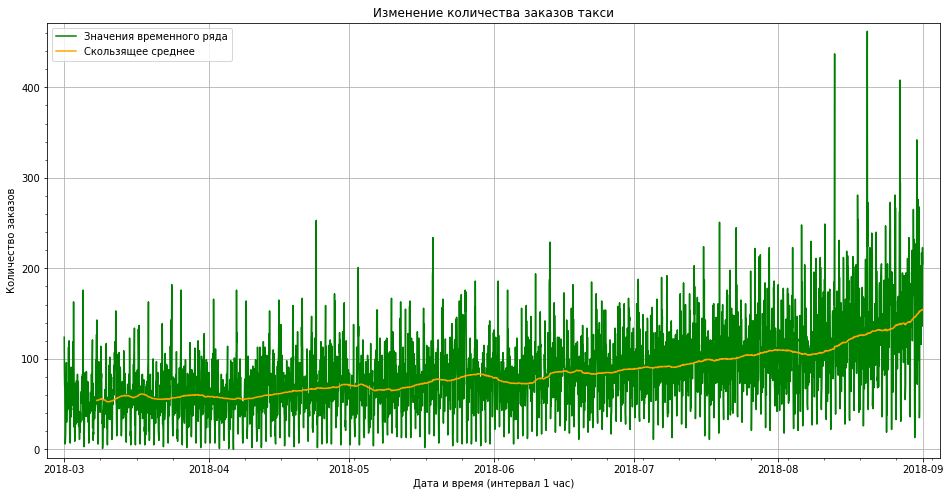

In [8]:
rolling_mean = main_data.rolling(168).mean()

plt.figure(figsize=(16, 8))
plt.plot(main_data, color='g', label = 'Значения временного ряда')
plt.plot(rolling_mean, color='orange', label = 'Скользящее среднее')
plt.legend(loc='upper left')
plt.minorticks_on()
plt.grid(True)
plt.margins(0.02)
plt.xlabel('Дата и время (интервал 1 час)')
plt.ylabel('Количество заказов')
plt.title('Изменение количества заказов такси')
plt.show()

Временной ряд не выглядит стационарным. С увеличением времени наблюдается постепенное увеличение среднего числа заказов. Это хорошо видно по скользящему среднему.

Теперь отобразим тренды, сезонность и остаток. Подписывать названия осей не будем, чтобы не было избытка информации.

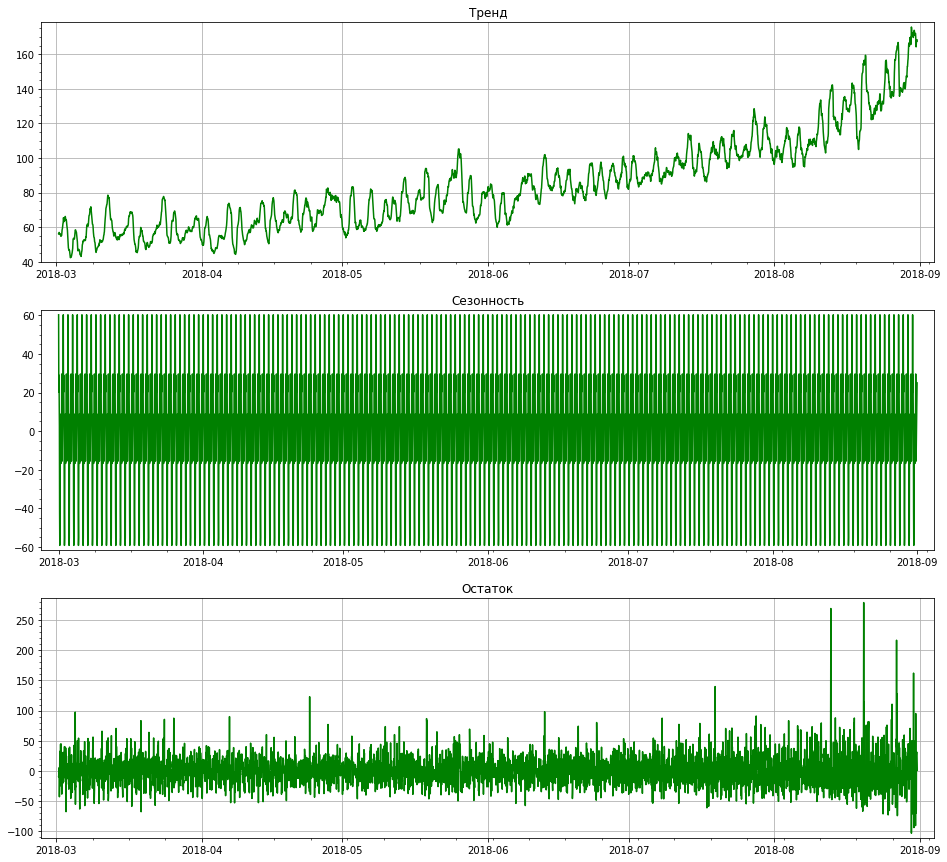

In [9]:
decomposed = seasonal_decompose(main_data)

plt.figure(figsize=(16, 15))
plt.subplot(311)
plt.plot(decomposed.trend, color='g') 
plt.minorticks_on()
plt.grid(True)
plt.margins(0.02)
plt.title('Тренд')

plt.subplot(312)
plt.plot(decomposed.seasonal, color='g') 
plt.minorticks_on()
plt.margins(0.02)
plt.title('Сезонность')

plt.subplot(313)
plt.plot(decomposed.resid,  color='g') 
plt.minorticks_on()
plt.grid(True)
plt.margins(0.02)
plt.title('Остаток')

plt.show()

График тренда показывает стабильное увеличение числа заказов со временем. График сезонности получился слишком сжатым, необходимо изменить его масштаб. По графику остатка ничего сказать нельзя.

Отобразим график сезонности для среза данных за 5 дней примерно в середине временного ряда.

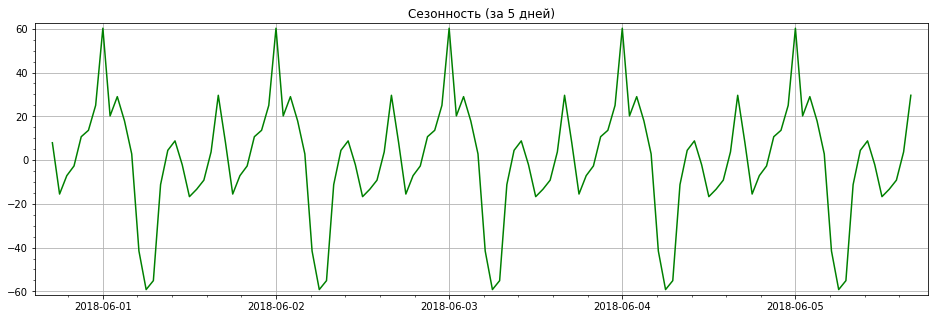

In [10]:
plt.figure(figsize=(16, 5))
plt.subplot()
plt.plot(decomposed.seasonal[2201:2321], color='g') 
plt.minorticks_on()
plt.grid(True)
plt.margins(0.02)
plt.title('Сезонность (за 5 дней)')
plt.show()

По графику наблюдается следующая сезонность в пределах одного дня: количество заказов такси увеличивается к вечеру и достигает пика в полночь. Минимум заказов приходится на ранние утренние часы. Это хорошо объясняется здравой логикой - вечером люди заказывают такси после разных мероприятий или после походов в гости.

На этом анализ временного ряда закончен.

## Построение моделей

### Подготовка признаков

Создадим функцию для добавления признаков для дальнейшего обучения моделей. По условию задачи горизонт планирования равен одному часу. Поэтому добавим признак *hour*. Также добавим скользящее среднее за 12 часов, а также сдвиги от 1 до 3 часов. При расчёте скользящего среднего учтём только левую границу окна через параметр *closed*, чтобы не учитывать текущее значение ряда.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['hour'] = data.index.hour
    new_data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size, closed='left').mean()
    for lag in range(1, max_lag+1):
        new_data[f'lag_{lag}'] = data['num_orders'].shift(lag) 
    return new_data

In [12]:
main_data_p = make_features(main_data, 3, 12)
main_data_p.head(26)

,num_orders,hour,rolling_mean,lag_1,lag_2,lag_3
datetime,,,,,,
2018-03-01 00:00:00,124,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,NaN,124.0,NaN,NaN
2018-03-01 02:00:00,71,2,NaN,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,NaN,71.0,85.0,124.0
2018-03-01 04:00:00,43,4,NaN,66.0,71.0,85.0
2018-03-01 05:00:00,6,5,NaN,43.0,66.0,71.0
2018-03-01 06:00:00,12,6,NaN,6.0,43.0,66.0
2018-03-01 07:00:00,15,7,NaN,12.0,6.0,43.0
2018-03-01 08:00:00,34,8,NaN,15.0,12.0,6.0


Новые признаки добавились успешно. 

Удалим строки с пропусками.

In [13]:
main_data_p.dropna(inplace=True)
main_data_p.isna().sum()

num_orders      0
hour            0
rolling_mean    0
lag_1           0
lag_2           0
lag_3           0
dtype: int64

Удаление пропусков прошло успешно.

Теперь разделим данные на обучающую и тестовую выборки. Валидационную выборку создавать не надо, так как при построении моделей будет использоваться кросс-валидация. После создания выборок проверим не только их размер, но и отсутствие перемешивания данных.

In [14]:
train, test = train_test_split(main_data_p, shuffle=False, test_size=0.1)

print(train.shape)
print(test.shape)
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

(3963, 6)
(441, 6)
2018-03-01 12:00:00 2018-08-13 14:00:00
2018-08-13 15:00:00 2018-08-31 23:00:00


Разделение прошло верно. 

Выделим из выборок обычные и целевые признаки.

In [15]:
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Теперь выполним масштабирование признаков, так как далее одна из моделей будет линейная (модель линейной регрессии). Для остальных моделей масштабирование не нужно, но его наличие не повлияет на результаты. Создавать отдельные выборки без масштабирования не будем.

In [16]:
scaler = StandardScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

### Функции расчёта метрики, времени, scorer и cv_estimator

Так как в проекте требуется оценивать метрику RMSE, то создадим отдельную функцию для расчёта этой метрики и scorer, который потом будем использовать как параметр в функциях cross_val_score и GridSearchCV. Также не забудем про параметр greater_is_better, указывающий какое значение метрики лучше - большое или маленькое.

In [17]:
def rmse_score(target, predictions):
    return mean_squared_error(target, predictions)**0.5

scorer_rmse = make_scorer(rmse_score, greater_is_better=False)

В процессе работы над проектом были выявлены повторяющиеся участки программного кода, связанные с обучением модели, подсчётом времени и метрики качества. Поэтому создадим функцию, которая будет обучать модель, получать предсказания по тестовой выборке и рассчитывать время этих операций. Функция пригодится на этапе тестирования моделей.

In [18]:
def model_routine(model, train_features, train_target, test_features, test_target):
    time1 = time.time()
    model.fit(train_features, train_target)
    time2 = time.time()
    fit_time = time2 - time1

    time1 = time.time()
    predictions = model.predict(test_features)
    time2 = time.time()
    predict_time = time2 - time1 
    
    rmse = rmse_score(test_target, predictions)
    
    return rmse, fit_time, predict_time, predictions

Для выполнения кросс-валидации при работе с временными рядами необходимо создать отдельный cv_estimator, который далее можно будет использовать в функциях cross_val_score и GridSearchCV.

In [19]:
tscv = TimeSeriesSplit(n_splits=8)

### Константная модель

Построим константную модель, которая будет предсказывать всегда средние значения. Посчитанная метрика качества данной модели позволит в дальнейшем лучше оценить результаты реальных моделей. Качество модели будем оценивать метрикой RMSE c помощью кросс-валидации. Для константной модели применение кросс-валидации не обязательно. Но всё равно применим её для чистоты эксперимента, так как в дальнейшем метрика RMSE будет определяться через кросс-валидацию (и непосредственно через функцию cross_val_score, и через функцию GridSearchCV).

In [20]:
model = DummyRegressor()
scores = cross_val_score(model, train_features, train_target, cv=tscv, scoring=scorer_rmse, n_jobs=-1)
RMSE = abs(np.mean(scores))
print(f'Константная модель имеет значение RMSE: {RMSE:.2f}')

Константная модель имеет значение RMSE: 39.48


**Вывод:** качество предсказания крайне низкое, но для константной модели вполне ожидаемое. Планируемые к построению в дальнейшем реальные модели должны значительно превысить полученное значение RMSE.

### Модель линейной регрессии

Построим теперь модель линейной регрессии и посмотрим на результат. Для расчёта метрики RMSE применим технику кросс-валидации.

In [21]:
model = LinearRegression(n_jobs=-1)
scores = cross_val_score(model, train_features, train_target, cv=tscv, scoring=scorer_rmse)
RMSE = abs(np.mean(scores))
print(f'Модель линейной регрессии имеет значение RMSE: {RMSE:.2f}')

Модель линейной регрессии имеет значение RMSE: 31.85


**Вывод:** при использовании модели линейной регрессии значение метрики RMSE заметно лучше, чем у константной модели. Но, вероятно, другие реальные модели покажут более выдающиеся результаты.

### Модель "Случайный лес"

Рассмотрим модель "Случайный лес" и подберём её оптимальные гиперпараметры. При работе функции GridSearchCV будет оцениваться метрика RMSE через созданную функцию rmse_score. Для ускорения обучения модели применён параметр n_jobs=-1, что означает использование всех ядер и потоков процессора.

In [22]:
%%time

estimator = RandomForestRegressor(random_state = 123, n_jobs=-1)
parameters = {'n_estimators': range(80, 151, 10),
              'max_depth': range(6,16,1)
             }
clf = GridSearchCV(estimator, parameters, scoring=scorer_rmse, cv=tscv, n_jobs=-1)
clf.fit(train_features, train_target)

CPU times: total: 2.09 s
Wall time: 21.4 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': range(6, 16),
                         'n_estimators': range(80, 151, 10)},
             scoring=make_scorer(rmse_score, greater_is_better=False))

In [23]:
display(clf.best_params_)
display(clf.best_estimator_)
display(clf.best_score_)

{'max_depth': 13, 'n_estimators': 150}

RandomForestRegressor(max_depth=13, n_estimators=150, n_jobs=-1,
                      random_state=123)

-24.999409023291506

Сохраним все параметры с названием модели в словаре, чтобы использовать в разделе 4. 

In [24]:
best_models = {}
best_models['forest'] = clf.best_estimator_

Теперь создадим модель "Случайный лес" с подобранными гиперпараметрами и получим значение RMSE.

In [25]:
model = clf.best_estimator_
RMSE = abs(clf.best_score_)
print(f'Модель "Случайный лес" имеет значение RMSE: {RMSE:.2f}')

Модель "Случайный лес" имеет значение RMSE: 25.00


**Вывод:** модель "Случайный лес" показала ожидаемо ещё более высокий результат, чем модель линейной регрессии. Рассмотрим далее модель градиентного бустинга.

### Модель LightGBM

Построим модель градиентного бустинга LightGBM. Гиперпараметры модели как и ранее подберём с помощью GridSearchCV. 

In [26]:
%%time

estimator = LGBMRegressor(verbosity = -1, force_col_wise=True, random_state = 123)
parameters = {'n_estimators': [100, 300, 500, 700],
              'num_leaves': [21,31,41,51],
              'learning_rate':[0.001, 0.01, 0.1]
             }
clf = GridSearchCV(estimator, parameters, scoring=scorer_rmse, cv=tscv, n_jobs=-1)
clf.fit(train_features, train_target)

CPU times: total: 1.83 s
Wall time: 36.7 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=LGBMRegressor(force_col_wise=True, random_state=123,
                                     verbosity=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': [100, 300, 500, 700],
                         'num_leaves': [21, 31, 41, 51]},
             scoring=make_scorer(rmse_score, greater_is_better=False))

In [27]:
display(clf.best_params_)
display(clf.best_estimator_)
display(clf.best_score_)

{'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 31}

LGBMRegressor(force_col_wise=True, learning_rate=0.01, n_estimators=500,
              random_state=123, verbosity=-1)

-24.937053488390163

Сохраним все параметры с названием модели в словаре, чтобы использовать в разделе 4. 

In [28]:
best_models['lightgbm'] = clf.best_estimator_

Теперь создадим модель LightGBM с подобранными гиперпараметрами и получим значение RMSE.

In [29]:
model = clf.best_estimator_
RMSE = abs(clf.best_score_)
print(f'Модель LightGBM имеет значение RMSE: {RMSE:.2f}')

Модель LightGBM имеет значение RMSE: 24.94


**Вывод:** модель LightGBM, как и ожидалось, показала наилучший результат - самое низкое значение метрики RMSE в сравнении с другими рассмотренными моделями.

## Тестирование моделей

Гиперпараметры для рассмотренных моделей успешно подобраны.Также получены значения метрики RMSE с помощью кросс-валидации. Теперь проверим работу моделей на тестовой выборке и получим уже другие значения метрики RMSE, а также посчитаем время обучения и предсказания для каждой модели. Для этих целей уже была написана функция *model_routine* в разделе 3.2.

Для удобства создадим таблицу для хранения результатов.

In [30]:
model_results = pd.DataFrame({'Модель': [], 'RMSE':[], 'Время обучения, с': [], 'Время предсказания, с':[]})

Напишем функцию для отображения результатов работы моделей на графике.

In [31]:
def plot_results(model_name, predictions):
    plt.figure(figsize=(16, 6))
    plt.plot(test_target, color='g', label = 'Значения временного ряда')
    predictions = pd.Series(predictions, index=test_target.index)
    plt.plot(predictions, color='orange', label = 'Предсказания модели')
    plt.legend(loc='upper left')
    plt.minorticks_on()
    plt.grid(True)
    plt.margins(0.02)
    plt.xlabel('Дата и время (интервал 1 час)')
    plt.ylabel('Количество заказов')
    plt.title(f'Сравнение предсказаний модели {model_name} с реальными значениями')
    plt.show()

Последовательно построим модели с подобранными гиперпараметрами, посчитаем необходимые величины и занесём их в таблицу. Для интереса также посмотрим на результат работы константной модели на тестовой выборке. Построим графики для сравнения предсказаний моделей и реальных значений временного ряда (не будем строить только график для константной модели).

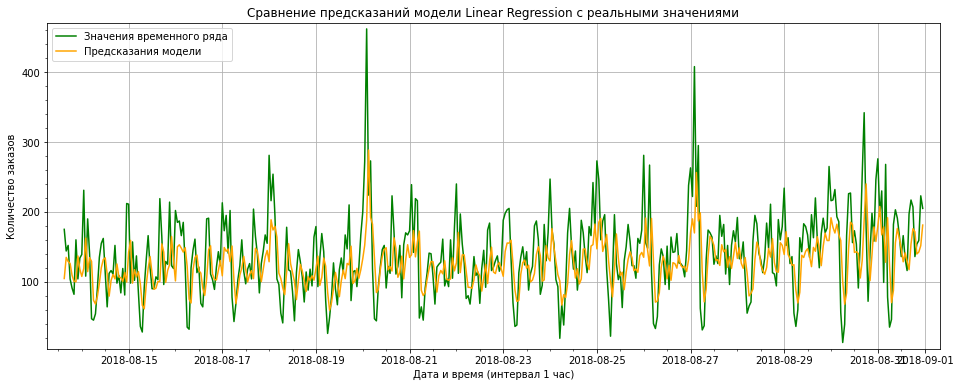

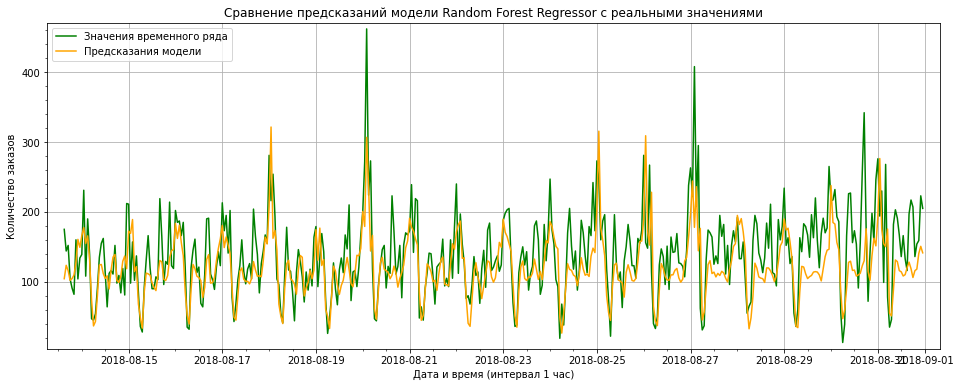

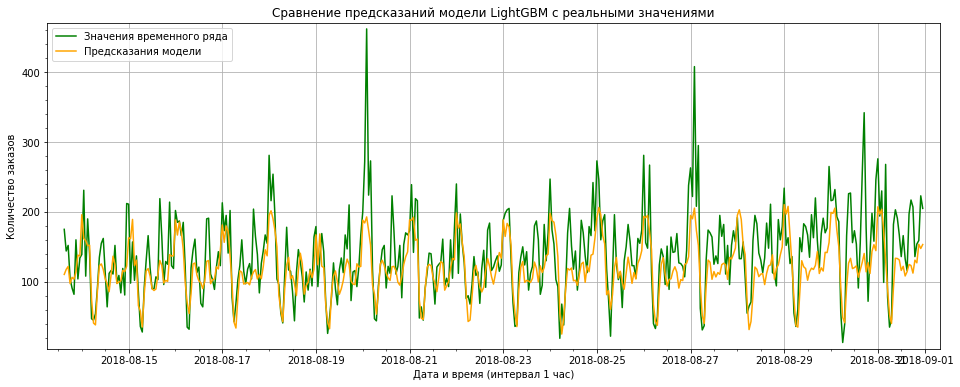

In [32]:
model = DummyRegressor()
rmse, fit_time, predict_time, predictions = model_routine(model, train_features, train_target, test_features, test_target)
model_results.loc[0] = ['Dummy Regressor', rmse, fit_time, predict_time]

model = LinearRegression()
rmse, fit_time, predict_time, predictions = model_routine(model, train_features, train_target, test_features, test_target)
model_results.loc[1] = ['Linear Regression', rmse, fit_time, predict_time]
plot_results('Linear Regression', predictions)

model = best_models['forest']
rmse, fit_time, predict_time, predictions = model_routine(model, train_features, train_target, test_features, test_target)
model_results.loc[2] = ['Random Forest Regressor', rmse, fit_time, predict_time]
plot_results('Random Forest Regressor', predictions)

model = best_models['lightgbm']
rmse, fit_time, predict_time, predictions = model_routine(model, train_features, train_target, test_features, test_target)
model_results.loc[3] = ['LightGBM', rmse, fit_time, predict_time]
plot_results('LightGBM', predictions)

По графику результатов для линейной регрессии видно, что модель сильнее всего ошибается в максимальных и минимальных значениях. Другие две модели на минимальных значениях особо не ошибаются, но на максимальных тоже показывают весомые расхождения с реальными значениями.

Посмотрим теперь таблицу с численными результатами.

In [33]:
model_results

,Модель,RMSE,"Время обучения, с","Время предсказания, с"
0,Dummy Regressor,84.781905,0.000000,0.000000
1,Linear Regression,52.749922,0.000000,0.000000
2,Random Forest Regressor,46.549334,0.183041,0.015004
3,LightGBM,45.086212,0.144860,0.000000


**Вывод:** все реальные модели показали худшие результаты на тестовой выборке в сравнении с результатами на обучающей (примерно в 1,5-2 раза). Это говорит о том, что модели переобучились или недообучились. 

Так как по условию задачи значение метрики RMSE на тестовой выборке должно быть не более 48, то по этому критерию подходят модели "Случайный лес" и LightGBM. Последняя показала наилучший результат по качеству прогноза, лишь незначительно уступив по времени обучения. Для решения задачи в проекте выбираем модель LightGBM.

## Общий вывод

В проекте была выполнена загрузка временного ряда из источника и его предварительное изучение. Проведено ресемплирование ряда по одному часу.

Далее проведён анализ временного ряда:
- по графику выявлено, что ряд нестационарный. С увеличением времени наблюдается постепенное увеличение среднего числа заказов;
- ряд разложен на три составляющие: тренд, сезонность и остаток. График тренда показывает стабильное увеличение числа заказов со временем. По графику сезонности наблюдается зависимость в пределах одного дня: количество заказов такси увеличивается к вечеру и достигает пика в полночь.

Следующим шагом выполнена подготовка признаков для дальнейшего обучения моделей: 
- в данные добавлены дополнительные признаки: скользящее среднее за 12 часов, а также сдвиги от 1 до 3 часов;
- данные разделены на тренировочную и тестовую выборки;
- произведено масштабирование обучающих признаков.

Затем было произведено построение четырёх моделей, одна из которых константная, а остальные реальные. Результаты работы константной модели позволили лучше оценить в дальнейшем результаты работы реальных моделей. Из реальных моделей были построены: модель линейной регрессии, модель "Случайный лес" и модель градиентного бустинга LightGBM. Предсказания моделей выполнялись на обучающей выборке, а метрика RMSE считалась на основе кросс-валидации.Наилучшие результаты по качеству предсказания показала модель LightGBM. 

Далее была проверена работа всех моделей на тестовой выборке. Все реальные модели показали худшие результаты на тестовой выборке в сравнении с результатами на обучающей. Это говорит о том, что модели переобучились или недообучились. 

Так как по условию задачи значение метрики RMSE на тестовой выборке должно быть не более 48, то по этому критерию подходят модели "Случайный лес" и LightGBM. Последняя показала наилучший результат по качеству прогноза, лишь незначительно уступив по времени обучения. Для решения задачи в проекте была выбрана модель LightGBM.